In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
import timestring
from scipy import stats

# Nomination Analysis
This notebook analyzes URLs outputted by EDGI's Nomination Tool. 

**Note**: In this analysis, the term "uncrawlable" is avoided as it is not an appropriate representation of what was nominated. Instead, the term "pages with data" is used. This corresponds to URLs that are hosting information or data that is flagged for archiving and "data" is used in a broad sense to mean collections of files, FTP pages, .


**This analysis includes**:
- Numbers for unique nominated URLs vs. pages with data
- Breakdown of numbers above by agency
- Progess of primer line completion. **Disclaimer**: Using total number of nominated URLs is NOT a good metric to use to understand how much work was done or if an agency was covered. Completion of a primer lines are the best way we know at the moment to denote that a section of a website was screened and seeded appropriately.

Toly Rinberg - April 1, 2017

In [7]:
# Import Data
#
df_raw = pd.read_csv('NominationToolOutput_121716to040117_cleaned_anon.csv', encoding = "ISO-8859-1", low_memory=False)
agency_db = pd.read_csv('agency_database.csv',encoding = "ISO-8859-1")
primer_db = pd.read_csv('primer_db_040117.csv',encoding = "ISO-8859-1")

In [8]:
#Initialize new columns for rows that will be added
N_raw = len(df_raw)
df_raw["delta_days"] = ""
df_raw["unique"] = ""
df_raw["date"] = ""

In [9]:
#Set up a unique key for each entry. The reason to do this is because for some reason 
#there are duplicate entries and this is a reliable way to get rid of those entries
ref_date =  datetime.strptime('12/16/2016', '%m/%d/%Y')

for i in range(0, N_raw):
    df_raw.iat[i,-2] = df_raw.iat[i,0] + str(df_raw.iat[i,1]) + df_raw.iat[i,3] + df_raw.iat[i,6]
    df_raw.iat[i,-1] = datetime.strptime(df_raw['Timestamp'][i], '%m/%d/%Y %H:%M')
    delta_days = df_raw.iat[i,-1]- ref_date
    df_raw.iat[i,-3] = delta_days.days

In [10]:
#Get rid of duplicate entries. Note that this is NOT getting rid of duplicate URLs, but entire rows that are the same.
df = df_raw.drop_duplicates('unique').copy()
N = len(df)

## Cleaning and Normalizing

In [11]:
#Convert all 'Yes' --> 1 and NaN --> 0
#There must be a better way to just select the columns you care about, but I did this in a rush and this works:
df['Uncrawlable'].replace(('Yes', np.nan), (1, 0), inplace=True)
df['Visualization/Interactive'].replace(('Yes', np.nan), (1, 0), inplace=True)
df['Files'].replace(('Yes', np.nan), (1, 0), inplace=True)
df['FTP'].replace(('Yes', np.nan), (1, 0), inplace=True)
df['Database'].replace(('Yes', np.nan), (1, 0), inplace=True)
df['Agency ID'].replace(( np.nan), (0), inplace=True)
df['Subagency ID'].replace(( np.nan), (0), inplace=True)
df['Organization ID'].replace(( np.nan), (0), inplace=True)
df['Suborganization ID'].replace((np.nan), (0), inplace=True)
df['Subprimer ID'].replace((np.nan), (0), inplace=True)

In [12]:
#Establish a unique code based on the Agency Office Code and the Subprimer Numbers
code = df['Agency ID']*1e8 + df['Subagency ID']*1e6 + df['Organization ID']*1e4 + df['Suborganization ID']*1e2 + df['Subprimer ID']
df['code'] = code

In [13]:
#Add a new column that idenitifies if the entry corresponds to a "Nominated URL"
is_pageWithData = df['Uncrawlable'] + df['Visualization/Interactive'] + df['Files'] + df['FTP'] + df['Database'] > 0
df['is_pageWithData'] = is_pageWithData

## Make Unique URL list

In [14]:
#First, sort so that uncrawlables are all on the top
#Then drop duplicate URLs, which will remove all duplicates keeping the top most entry
#This ensures that if there are multiple nominations for the same URL, you will keep the pages with data nomination if that one exists.
df_un = df.sort_values(['is_pageWithData'], ascending=[False]).drop_duplicates('URL').copy()

##  Pages with Data to Archive

In [17]:
print('Number of Unique URLs: ' + str(len(df_un)))
print('Number of Pages with Data to Archive: ' + str(sum(df_un['is_pageWithData'])))
print('Percent Pages with Data to Archive: ' + str(np.round(1000*sum(df_un['is_pageWithData'])/len(df_un))/10 ) + '%')
print('')
print('Number of Pages with Many Files pages: ' + str(sum(df_un['Files'] == 1)))
print('Number of Pages with Visualization/Interactive Features: ' + str(sum(df_un['Visualization/Interactive'] == 1))    )
print('Number of Pages with a Database: ' + str(sum(df_un['Database'] == 1))    )
print('Number of FTP pages: ' + str(sum(df_un['FTP'] == 1))   )

Number of Unique URLs: 54933
Number of Pages with Data to Archive: 19719
Percent Pages with Data to Archive: 35.9%

Number of Pages with Many Files pages: 5683
Number of Pages with Visualization/Interactive Features: 6316
Number of Pages with a Database: 3175
Number of FTP pages: 650


## URLs by Agency

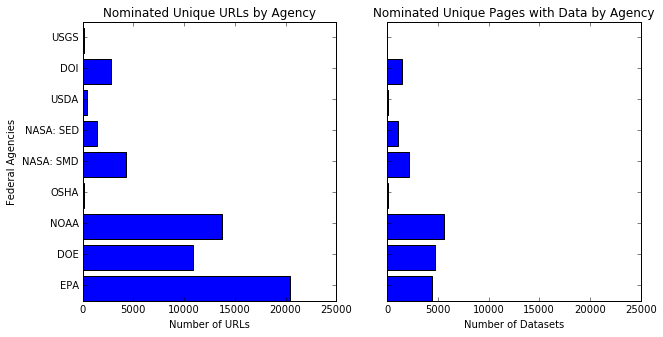

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(121)
count_seeds_agency_id, bins2 = np.histogram(df_un['Agency ID'], np.linspace(1,10,10));
plt.barh(bins2[0:-1],count_seeds_agency_id, alpha=1);
plt.yticks(agency_db['id_agency'][0:9]+0.5, agency_db['agency'][0:9]);
#np.sum(df['Agency ID'] == 1)
plt.xlabel('Number of URLs')
plt.ylabel('Federal Agencies')
plt.title('Nominated Unique URLs by Agency')

plt.subplot(122)
count_pageWithData_agency_id, bins2 = np.histogram(df_un['Agency ID'][df_un['is_pageWithData']==True], np.linspace(1,10,10));
plt.barh(bins2[0:-1],count_pageWithData_agency_id, alpha=1);
plt.yticks(agency_db['id_agency'][0:9]+0.5, '');
#np.sum(df['Agency ID'] == 1)
plt.xlabel('Number of Datasets')
plt.xlim([0,25000])
plt.title('Nominated Unique Pages with Data by Agency')


In [23]:
num_seeds_by_agency = pd.DataFrame({'Agency': agency_db['agency'][0:9], 
                                    'Number of URLs': count_seeds_agency_id, 
                                    'Number of Pages with Data': count_pageWithData_agency_id,
                                    'Percent Pages with Data': np.round(1000*count_pageWithData_agency_id/count_seeds_agency_id)/10})
num_seeds_by_agency

,Agency,Number of Pages with Data,Number of URLs,Percent Pages with Data
0,EPA,4411,20455,21.6
1,DOE,4758,10912,43.6
2,NOAA,5589,13690,40.8
3,OSHA,45,113,39.8
4,NASA: SMD,2157,4284,50.4
5,NASA: SED,1036,1458,71.1
6,USDA,107,397,27.0
7,DOI,1431,2763,51.8
8,USGS,22,98,22.4


## Primer Progress

#### This analysis takes the primer progress as input and plots the primer lines that were completed as a function of time.

In [24]:
primer_lines = primer_db[primer_db['is_office']!='1'].copy()
primer_lines['Office Code'] = pd.to_numeric(primer_lines['Office Code'])
count_seeds_per_line = np.zeros(len(primer_lines))

In [25]:
for j in range(0,len(primer_lines)):
    count_seeds_per_line[j] = np.sum(df_un['code'] == primer_lines['Office Code'].iloc[j])

<Container object of 711 artists>

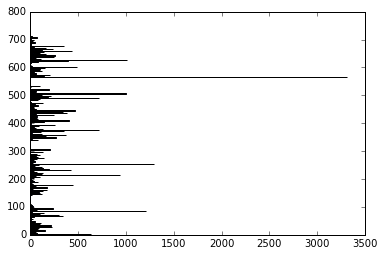

In [26]:
plt.barh(range(0,len(primer_lines)),count_seeds_per_line)

In [27]:
count_primer_lines_per_day = np.zeros((len(primer_lines)-1,100))
for i in range(0,100):
    count_primer_lines_per_day[:,i], bins = np.histogram(df['code'][df['delta_days'] == i], np.sort(primer_lines['Office Code']))

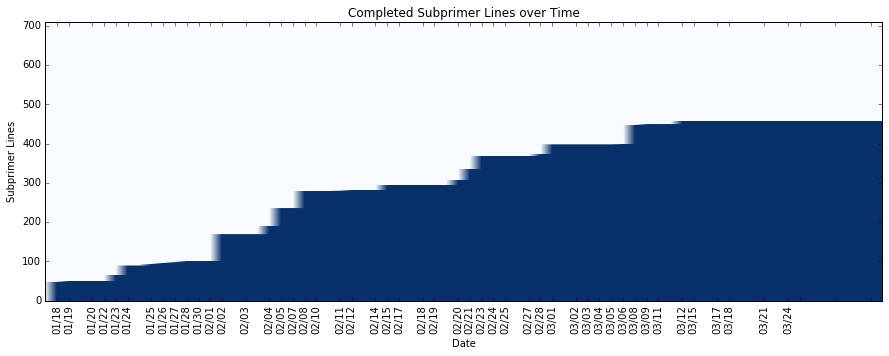

In [30]:
np.unique(df['delta_days'])
dates = np.unique(df['date'])

plt.figure(figsize=(15,5))
cumul_count_primer_lines_per_day = np.cumsum(count_primer_lines_per_day,axis=1)
plt.imshow(np.sort(cumul_count_primer_lines_per_day,axis = 0)[::-1], clim=(9.5,10), aspect='auto', cmap="Blues")
dates_list = [datetime.strftime(date, '%m/%d') for date in dates]
plt.xticks(np.unique(df['delta_days'][0:-3]), np.unique(dates_list)[0:-3],rotation='vertical');
plt.xlim([28,99])
plt.ylim(plt.ylim()[::-1])
plt.ylabel('Subprimer Lines');plt.xlabel('Date');plt.title('Completed Subprimer Lines over Time')